In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy.signal as signal
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Dataset path pointing to 'dreamt'
dataset_path = r"C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt"

print("Dataset contents:")
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/")
    else:
        print(f"📄 {item}")

# Collect subject folders (e.g., s002, s003, ...)
subject_folders = [
    f for f in os.listdir(dataset_path)
    if f.lower().startswith('s') and os.path.isdir(os.path.join(dataset_path, f))
]

Dataset contents:
📁 .ipynb_checkpoints/
📄 S002.csv
📄 S003.csv
📄 S004.csv
📄 S005.csv
📄 S006.csv
📄 S007.csv
📄 S008.csv
📄 S009.csv


In [4]:
subject_csvs = [
    f for f in os.listdir(dataset_path)
    if f.lower().endswith('.csv')
]

print(f"\nFound {len(subject_csvs)} subject CSV files: {subject_csvs}")

# Example: Load one subject CSV
sample_subject = 'S002.csv'
sample_path = os.path.join(dataset_path, sample_subject)

print(f"\nLoading {sample_subject} ...")
df = pd.read_csv(sample_path)

print("\nCSV Head:")
print(df.head())

print("\nCSV Info:")
print(df.info())


Found 8 subject CSV files: ['S002.csv', 'S003.csv', 'S004.csv', 'S005.csv', 'S006.csv', 'S007.csv', 'S008.csv', 'S009.csv']

Loading S002.csv ...

CSV Head:
   TIMESTAMP   BVP  ACC_X  ACC_Y  ACC_Z   TEMP       EDA    HR  Sleep_Stage
0   0.000000  5.14   31.0    8.0   55.0  35.53  0.073005  49.0            2
1   0.015625  4.28   31.0    8.0   55.0  35.53  0.073005  49.0            2
2   0.031250  3.51   31.0    8.0   55.0  35.53  0.073005  49.0            2
3   0.046875  3.02   31.0    8.0   55.0  35.53  0.073005  49.0            2
4   0.062500  2.94   28.0    8.0   55.0  35.53  0.073005  49.0            2

CSV Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013697 entries, 0 to 2013696
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   TIMESTAMP    float64
 1   BVP          float64
 2   ACC_X        float64
 3   ACC_Y        float64
 4   ACC_Z        float64
 5   TEMP         float64
 6   EDA          float64
 7   HR           float64
 8 

In [5]:
import os
import numpy as np
import pandas as pd
from scipy import signal

def process_subject_csv(csv_file, dataset_path):
    """
    Process one subject CSV file from dreamt dataset
    Returns: X (features), y (labels)
    """
    # Read CSV
    subject_path = os.path.join(dataset_path, csv_file)
    df = pd.read_csv(subject_path)

    # Select physiological signals
    ecg = df["BVP"].values          # using BVP as ECG-like signal
    eda = df["EDA"].values
    temp = df["TEMP"].values
    resp = df["ACC_Z"].values       # use Z-axis accel as respiration proxy
    acc = df[["ACC_X", "ACC_Y", "ACC_Z"]].values

    # Labels (Sleep_Stage: convert to binary example — Wake=0, Non-Wake=1)
    labels = df["Sleep_Stage"].astype(str).values
    # Example: treat "W" as wake=0, anything else as sleep=1
    y = np.array([0 if l.upper().startswith("W") else 1 for l in labels])

    # Windowing: 60s windows (assume sampling rate ~64Hz, adjust as needed)
    sampling_rate = 64
    window_size_seconds = 60
    window_size = window_size_seconds * sampling_rate

    X_list, y_list = [], []

    for i in range(0, len(ecg) - window_size, window_size // 2):
        # Window slices
        ecg_window = ecg[i:i+window_size]
        eda_window = eda[i:i+window_size]
        temp_window = temp[i:i+window_size]
        resp_window = resp[i:i+window_size]
        acc_window = acc[i:i+window_size]

        # Label majority for the window
        window_labels = y[i:i+window_size]
        if len(window_labels) == 0:
            continue
        window_label = np.argmax(np.bincount(window_labels))

        # Extract features
        features = extract_features(ecg_window, eda_window, temp_window, resp_window, acc_window)
        X_list.append(features)
        y_list.append(window_label)

    return np.array(X_list), np.array(y_list)


def extract_features(ecg, eda, temp, resp, acc):
    """
    Extract features from physiological signals
    """
    features = []

    # ECG/BVP features
    features.extend([np.mean(ecg), np.std(ecg), np.min(ecg), np.max(ecg)])

    # Heart rate variability (simple peak detection)
    try:
        peaks, _ = signal.find_peaks(ecg, height=np.mean(ecg), distance=30)
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / 64.0  # convert to seconds
            features.extend([np.mean(rr_intervals), np.std(rr_intervals),
                             np.min(rr_intervals), np.max(rr_intervals)])
        else:
            features.extend([0, 0, 0, 0])
    except:
        features.extend([0, 0, 0, 0])

    # EDA features
    features.extend([np.mean(eda), np.std(eda), np.max(eda) - np.min(eda)])

    # Temperature features
    features.extend([np.mean(temp), np.std(temp)])

    # Respiration (from ACC_Z)
    features.extend([np.mean(resp), np.std(resp)])

    # Accelerometer magnitude
    acc_mag = np.linalg.norm(acc, axis=1)
    features.extend([np.mean(acc_mag), np.std(acc_mag)])

    return features


# Main processing loop
dataset_path = r"C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt"

print("Processing dreamt dataset...")
X_all, y_all = [], []

# Loop through all subject CSVs
subject_csvs = [f for f in os.listdir(dataset_path) if f.lower().endswith('.csv')]

for csv_file in subject_csvs:
    try:
        print(f"Processing {csv_file}...")
        X, y = process_subject_csv(csv_file, dataset_path)
        if len(X) > 0 and len(y) > 0:
            X_all.append(X)
            y_all.append(y)
            print(f"✅ Processed {csv_file}: {X.shape} features, {y.shape} labels")
        else:
            print(f"⚠ No data processed for {csv_file}")
    except Exception as e:
        print(f"❌ Error processing {csv_file}: {e}")

# Combine all subjects
if len(X_all) > 0:
    X = np.vstack(X_all)
    y = np.hstack(y_all)

    print(f"\nFinal dataset shape: {X.shape}")
    print(f"Class distribution: {np.bincount(y)}")

    # Save processed data
    np.save('X_features.npy', X)
    np.save('y_labels.npy', y)
    print("✅ Processed data saved to X_features.npy and y_labels.npy")
else:
    print("❌ No data processed. Please check dataset format.")


Processing dreamt dataset...
Processing S002.csv...
✅ Processed S002.csv: (1047, 17) features, (1047,) labels
Processing S003.csv...
✅ Processed S003.csv: (1067, 17) features, (1067,) labels
Processing S004.csv...
✅ Processed S004.csv: (1031, 17) features, (1031,) labels
Processing S005.csv...
✅ Processed S005.csv: (1036, 17) features, (1036,) labels
Processing S006.csv...
✅ Processed S006.csv: (1112, 17) features, (1112,) labels
Processing S007.csv...
✅ Processed S007.csv: (1023, 17) features, (1023,) labels
Processing S008.csv...
✅ Processed S008.csv: (1063, 17) features, (1063,) labels
Processing S009.csv...
✅ Processed S009.csv: (1024, 17) features, (1024,) labels

Final dataset shape: (8403, 17)
Class distribution: [   0 8403]
✅ Processed data saved to X_features.npy and y_labels.npy


In [6]:
import numpy as np

X = np.load("X_features.npy")
y = np.load("y_labels.npy")

print("X shape:", X.shape)
print("y shape:", y.shape)
print("y unique classes:", np.unique(y))


X shape: (8403, 17)
y shape: (8403,)
y unique classes: [1]


In [7]:
print("Sample X row:", X[0])
print("Sample y value:", y[0])


Sample X row: [-3.06223958e-02  1.04438897e+01 -1.21500000e+02  7.99100000e+01
  8.14854452e-01  1.65271885e-01  4.68750000e-01  1.25000000e+00
  6.79085333e-02  1.99602310e-03  1.02460000e-02  3.56531667e+01
  7.95296940e-02 -1.03723958e+01  1.83687452e+01  6.50581874e+01
  4.46257192e+00]
Sample y value: 1


In [8]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy import signal

dataset_path = r"C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt"

def extract_features(ecg, eda, temp, resp, acc):
    features = []
    # Simple features
    features.extend([np.mean(ecg), np.std(ecg), np.min(ecg), np.max(ecg)])
    features.extend([np.mean(eda), np.std(eda), np.max(eda)-np.min(eda)])
    features.extend([np.mean(temp), np.std(temp)])
    features.extend([np.mean(resp), np.std(resp)])
    acc_mag = np.linalg.norm(acc, axis=1)
    features.extend([np.mean(acc_mag), np.std(acc_mag)])
    for axis in range(3):
        features.extend([np.mean(acc[:, axis]), np.std(acc[:, axis])])
    return features

X_all, y_all = [], []
le = LabelEncoder()

for file in os.listdir(dataset_path):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(dataset_path, file))
        # Use only needed columns
        signals = ['BVP','EDA','TEMP','ACC_X','ACC_Y','ACC_Z']
        for col in signals + ['Sleep_Stage']:
            if col not in df.columns:
                df[col] = 0  # fill missing columns if any
        # Encode Sleep_Stage
        df['Sleep_Stage'] = le.fit_transform(df['Sleep_Stage'].astype(str))
        ecg = df['BVP'].values
        eda = df['EDA'].values
        temp = df['TEMP'].values
        resp = df['ACC_Z'].values
        acc = df[['ACC_X','ACC_Y','ACC_Z']].values
        y = df['Sleep_Stage'].values

        # Windowing (30s window, 64Hz sampling)
        fs = 64
        win_sec = 60
        win_size = min(win_sec*fs, len(ecg))
        if win_size==0:
            continue
        step = win_size // 2
        for i in range(0, len(ecg)-win_size+1, step):
            X_all.append(extract_features(ecg[i:i+win_size],
                                          eda[i:i+win_size],
                                          temp[i:i+win_size],
                                          resp[i:i+win_size],
                                          acc[i:i+win_size]))
            y_all.append(np.argmax(np.bincount(y[i:i+win_size])))

X = np.array(X_all)
y = np.array(y_all)

print("Final feature shape:", X.shape)
print("Final labels shape:", y.shape)
np.save("X_features.npy", X)
np.save("y_labels.npy", y)
print("Saved X_features.npy and y_labels.npy")


Final feature shape: (8403, 19)
Final labels shape: (8403,)
Saved X_features.npy and y_labels.npy


In [9]:
import numpy as np

# Load labels
y = np.load("y_labels.npy")

# Unique classes and counts
classes, counts = np.unique(y, return_counts=True)

print("Class distribution:")
for c, cnt in zip(classes, counts):
    print(f"Class {c}: {cnt} samples")

# Optional: show as percentages
total = len(y)
print("\nClass distribution (percentages):")
for c, cnt in zip(classes, counts):
    print(f"Class {c}: {cnt/total*100:.2f}%")


Class distribution:
Class 0: 640 samples
Class 1: 3197 samples
Class 2: 680 samples
Class 3: 1835 samples
Class 4: 1186 samples
Class 5: 865 samples

Class distribution (percentages):
Class 0: 7.62%
Class 1: 38.05%
Class 2: 8.09%
Class 3: 21.84%
Class 4: 14.11%
Class 5: 10.29%


In [10]:
from sklearn.utils import resample
import numpy as np

X = np.load("X_features.npy")
y = np.load("y_labels.npy")

X_resampled = []
y_resampled = []

classes = np.unique(y)
max_count = max([np.sum(y==c) for c in classes])

for c in classes:
    X_c = X[y==c]
    y_c = y[y==c]
    X_up, y_up = resample(X_c, y_c, replace=True, n_samples=max_count, random_state=42)
    X_resampled.append(X_up)
    y_resampled.append(y_up)

X_bal = np.vstack(X_resampled)
y_bal = np.hstack(y_resampled)

# Check new distribution
classes, counts = np.unique(y_bal, return_counts=True)
print("Balanced class distribution:")
for c, cnt in zip(classes, counts):
    print(f"Class {c}: {cnt}")


Balanced class distribution:
Class 0: 3197
Class 1: 3197
Class 2: 3197
Class 3: 3197
Class 4: 3197
Class 5: 3197


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# 3️⃣ Train/Validation/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_bal
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# 4️⃣ Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ Reshape for CNN input (samples, timesteps, features=1)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"Reshaped training set: {X_train_reshaped.shape}")
print(f"Reshaped validation set: {X_val_reshaped.shape}")
print(f"Reshaped test set: {X_test_reshaped.shape}")

# 6️⃣ Save the scaler for later inference
joblib.dump(scaler, "dreamt_scaler.pkl")
print("Feature scaler saved as 'dreamt_scaler.pkl'")


Training set: (12276, 19), (12276,)
Validation set: (3069, 19), (3069,)
Test set: (3837, 19), (3837,)
Reshaped training set: (12276, 19, 1)
Reshaped validation set: (3069, 19, 1)
Reshaped test set: (3837, 19, 1)
Feature scaler saved as 'dreamt_scaler.pkl'


In [22]:
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Path to dataset folder
dataset_path = r"C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt"

# Columns to drop (with NaN values)
drop_columns = ['IBI', 'Obstructive_Apnea', 'Central_Apnea', 'Hypopnea', 'Multiple_Events']

# Initialize label encoder
le = LabelEncoder()

# Collect all processed data
all_data = []

for file in os.listdir(dataset_path):
    if file.endswith(".csv"):
        file_path = os.path.join(dataset_path, file)
        print(f"Processing {file} ...")
        
        # Load dataset
        df = pd.read_csv(file_path)
        
        # Drop columns with mostly NaN
        df = df.drop(columns=drop_columns, errors="ignore")
        
        # Encode Sleep_Stage
        if 'Sleep_Stage' in df.columns:
            df['Sleep_Stage'] = le.fit_transform(df['Sleep_Stage'].astype(str))
        
        # Save back processed file
        save_path = os.path.join(dataset_path, f"processed_{file}")
        df.to_csv(save_path, index=False)
        print(f"Saved cleaned file as {save_path}")
        
        all_data.append(df)

# Merge all subjects into one DataFrame (if needed)
final_df = pd.concat(all_data, ignore_index=True)
print("\nFinal dataset shape:", final_df.shape)
print("Sleep stage classes:", le.classes_)


Processing S002.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S002.csv
Processing S003.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S003.csv
Processing S004.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S004.csv
Processing S005.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S005.csv
Processing S006.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S006.csv
Processing S007.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S007.csv
Processing S008.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S008.csv
Processing S009.csv ...
Saved cleaned file as C:\Users\ARUNKUMAR\Videos\sleep stage classification\dreamt\processed_S009.csv


**1-D CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

num_classes = 6  # 0–5

model = Sequential([
    Conv1D(filters=64, kernel_size=7, activation='relu', padding='same', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),  # <-- changed padding
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_sleep_cnn.keras',   # must end with .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



# Training
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8904 - loss: 0.2890
Epoch 1: val_loss improved from inf to 0.40447, saving model to best_sleep_cnn.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8904 - loss: 0.2891 - val_accuracy: 0.8752 - val_loss: 0.4045
Epoch 2/50
191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8868 - loss: 0.3008
Epoch 2: val_loss did not improve from 0.40447
192/192 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8868 - loss: 0.3008 - val_accuracy: 0.8576 - val_loss: 0.4444
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8959 - loss: 0.2812
Epoch 3: val_loss improved from 0.40447 to 0.37917, saving model to best_sleep_cnn.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8958 - loss: 0.2812 - val_accuracy: 0.8860 - val_loss: 0.3792
Epoch 4/50
191/192 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8975 - loss: 0.2642
Epoch 4: val_loss improved from 0.37917 to 0.34290, saving model to best_sle

In [20]:
model.save("1d_sleep_cnn.keras")


**LSTM**

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model2 = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])
model2.summary()

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 19, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,518 (470.77 KB)

 Trainable params: 120,518 (470.77 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_sleep_cnn.keras',   # must end with .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



# Training
history = model2.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9158 - loss: 0.2357
Epoch 1: val_loss improved from inf to 0.36957, saving model to best_sleep_cnn.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9158 - loss: 0.2356 - val_accuracy: 0.8941 - val_loss: 0.3696
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9146 - loss: 0.2386
Epoch 2: val_loss improved from 0.36957 to 0.35019, saving model to best_sleep_cnn.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9146 - loss: 0.2386 - val_accuracy: 0.9029 - val_loss: 0.3502
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9205 - loss: 0.2209
Epoch 3: val_loss did not improve from 0.35019
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9205 - loss: 0.2209 - val_accuracy: 0.9032 - val_loss: 0.3655
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9207 - loss: 0.2216
Epoch 4: val_loss improved from 0.35019 to 0.33533, saving model to best_s

In [29]:
model2.save("lstm_sleep_cnn.keras")

120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9101 - loss: 0.3388

Test Results:
Loss: 0.3100
Accuracy: 0.9150
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       639
           1       0.93      0.75      0.83       639
           2       0.94      0.98      0.96       640
           3       0.97      0.96      0.96       640
           4       0.87      0.94      0.90       640
           5       0.92      0.95      0.93       639

    accuracy                           0.92      3837
   macro avg       0.92      0.92      0.91      3837
weighted avg       0.92      0.92      0.91      3837



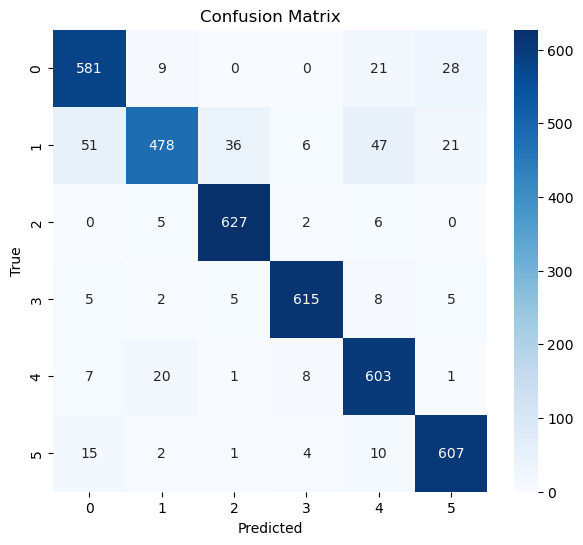

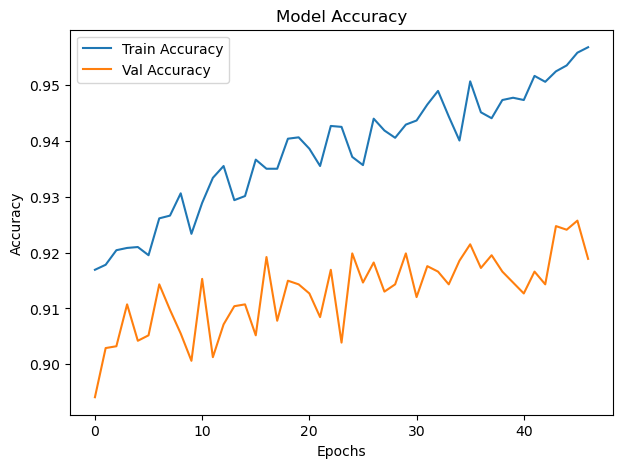

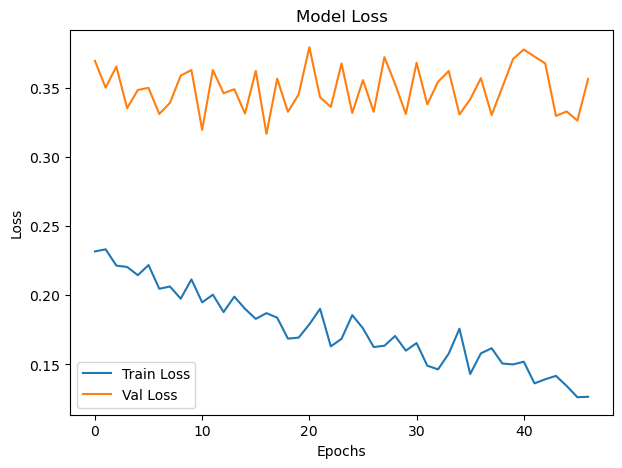

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Evaluate on test set
test_results = model.evaluate(X_test_reshaped, y_test, verbose=1)
print("\nTest Results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")

# 2. Predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 4. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 5. Training history plots
# Accuracy
plt.figure(figsize=(7,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Precision (if available)
if "precision" in history.history:
    plt.figure(figsize=(7,5))
    plt.plot(history.history["precision"], label="Train Precision")
    plt.plot(history.history["val_precision"], label="Val Precision")
    plt.title("Model Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# Recall (if available)
if "recall" in history.history:
    plt.figure(figsize=(7,5))
    plt.plot(history.history["recall"], label="Train Recall")
    plt.plot(history.history["val_recall"], label="Val Recall")
    plt.title("Model Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.show()


(12276, 19)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, Dense, Flatten

# CNN + BiLSTM hybrid model
cnn_bilstm_model = Sequential([
    # 1D CNN layers
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # BiLSTM layers
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    # Dense output layer
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')  # number of classes in sleep stage labels
])

# Compile model
cnn_bilstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_bilstm_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 17, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 6, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 3, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,542 (662.27 KB)

 Trainable params: 169,542 (662.27 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, Dense, BatchNormalization

cnn_bilstm_model2 = Sequential([
    # 1st CNN block
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # 2nd CNN block
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # 3rd CNN block (extra depth)
    Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # BiLSTM layers
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.3),

    # Dense layers
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile with a stronger optimizer
from tensorflow.keras.optimizers import Adam
cnn_bilstm_model2.compile(
    optimizer=Adam(learning_rate=1e-4),  # smaller LR for stable convergence
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_bilstm_model2.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 19, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 19, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 9, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 9, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 9, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 9, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 4, 512)              │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 4, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 2, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 2, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 2, 256)              │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,351,942 (5.16 MB)

 Trainable params: 1,350,150 (5.15 MB)

 Non-trainable params: 1,792 (7.00 KB)

**CNN BI-LSTM**

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_sleep_cnn.keras',   # must end with .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)



# Training
history = cnn_bilstm_model2.fit(
    X_train_reshaped, y_train,
    validation_data=(X_val_reshaped, y_val),
    epochs=70,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = cnn_bilstm_model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/70
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2277 - loss: 1.7625
Epoch 1: val_loss improved from inf to 1.79930, saving model to best_sleep_cnn.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 46s 115ms/step - accuracy: 0.2280 - loss: 1.7623 - val_accuracy: 0.1678 - val_loss: 1.7993
Epoch 2/70
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4120 - loss: 1.5074
Epoch 2: val_loss improved from 1.79930 to 1.46854, saving model to best_sleep_cnn.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.4122 - loss: 1.5069 - val_accuracy: 0.4370 - val_loss: 1.4685
Epoch 3/70
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5234 - loss: 1.2049
Epoch 3: val_loss improved from 1.46854 to 1.03659, saving model to best_sleep_cnn.keras
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.5235 - loss: 1.2048 - val_accuracy: 0.6096 - val_loss: 1.0366
Epoch 4/70
192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5758 - loss: 1.0772
Epoch 4: val_loss improved from

In [33]:
cnn_bilstm_model2.save("bilstm_sleep_cnn.keras")

120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.9076 - loss: 0.2842

Test Results:
Loss: 0.2695
Accuracy: 0.9101
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       639
           1       0.89      0.73      0.80       639
           2       0.92      0.99      0.96       640
           3       0.99      0.98      0.99       640
           4       0.87      0.95      0.91       640
           5       0.94      0.91      0.93       639

    accuracy                           0.91      3837
   macro avg       0.91      0.91      0.91      3837
weighted avg       0.91      0.91      0.91      3837



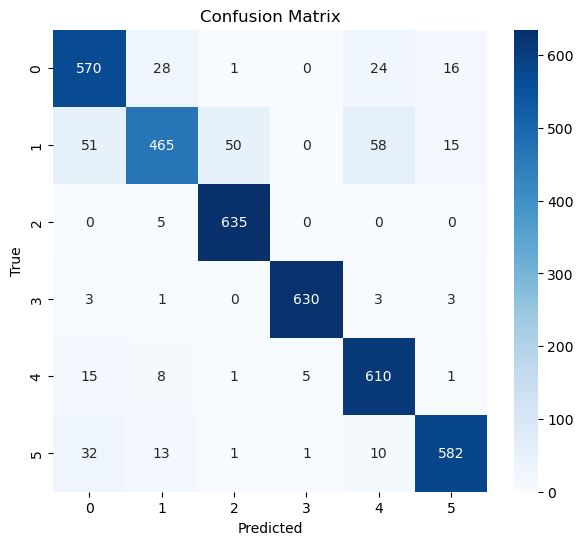

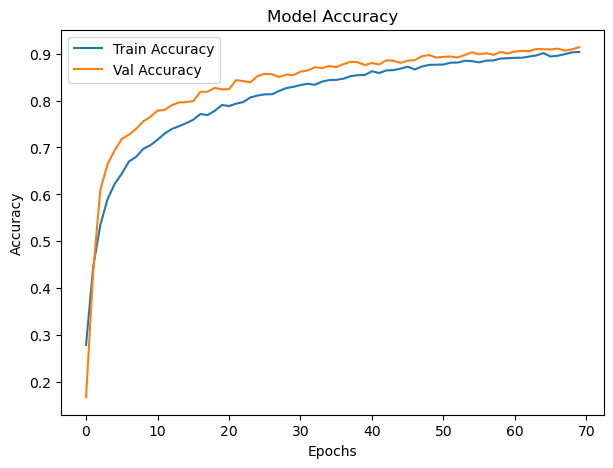

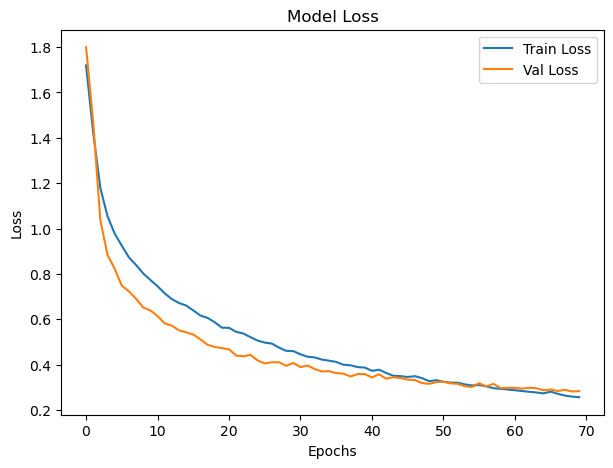

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



# 1. Evaluate on test set
test_results = cnn_bilstm_model2.evaluate(X_test_reshaped, y_test, verbose=1)
print("\nTest Results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")

# 2. Predictions
y_pred_probs = cnn_bilstm_model2.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 4. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 5. Training history plots
# Accuracy
plt.figure(figsize=(7,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Precision (if available)
if "precision" in history.history:
    plt.figure(figsize=(7,5))
    plt.plot(history.history["precision"], label="Train Precision")
    plt.plot(history.history["val_precision"], label="Val Precision")
    plt.title("Model Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

# Recall (if available)
if "recall" in history.history:
    plt.figure(figsize=(7,5))
    plt.plot(history.history["recall"], label="Train Recall")
    plt.plot(history.history["val_recall"], label="Val Recall")
    plt.title("Model Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.show()
